# Questão 2
## Operação de Turbofan no Ponto de Projeto

![turbofan_termodynamic_scheme](images/turbofan.svg)


In [128]:
import model_reference as mf
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import warnings

plt.style.use('seaborn')
warnings.filterwarnings('ignore')

## a)
Para situação de temperatura na saída da câmara de combustão de 1700 K, razão de compressão no compressor de 20, razão de pressão no fan de 1,4; varie a razão de passagem de zero (motor turbojato) até o máximo possível para estas condições de operação ao nível do mar e início da decolagem (Mach 0). 

* Em função da razão de passagem, apresente o comportamento do empuxo específico e consumo específico.

* Admitindo que a vazão de ar para o motor de razão de passagem igual zero (turbojato) é 100 kg/s, determine qual a vazão total de ar (total) e o consumo de combustível para as versões com razão de passagem diferente de zero de tal forma a propiciar o mesmo empuxo que a versão turbojato.

In [129]:
model_parameters = {
    # Atmospheric condition ##############################################
    'pa': 101.3, # [kPa]
    'ta': 288.3, # [K]
    'r': 288.3,  # [J/(kg*K)] Air Gas Constant
    # Components isentropic efficiencies #################################
    'n_d': 0.97,  # Difuser (Inlet)
    'n_f': 0.85,  # Fan
    'n_c': 0.85,  # High Pressure Compressor
    'n_b': 1.0,   # Combustion Chamber
    'n_t': 0.9,   # Compressor Turbine
    'n_tf': 0.9,  # Fan turbine
    'n_n': 0.98,  # Turbine Nozzle
    'n_nf': 0.98, # Fan Nozzle
    # Average air Cp/Cv inside each component ############################
    'gamma_d': 1.4,   # Difuser (Inlet)
    'gamma_f': 1.4,   # Fan
    'gamma_c': 1.37,  # High Pressure Compressor
    'gamma_b': 1.35,  # Combustion Chamber
    'gamma_t': 1.33,  # Compressor Turbine
    'gamma_tf': 1.33, # Fan turbine
    'gamma_n': 1.36,  # Turbine Nozzle
    'gamma_nf': 1.40, # Fan Nozzle
    # Engine parameters ##################################################
    'prc': 20,         # Crompressor Pressure Ratio
    'prf': 1.4,        # Fan Pressure Ratio
    'bypass_ratio': 0, # Initial value
    # Fuel parameters ####################################################
    'pc_fuel': 45000, # [kJ/kg] Heat of Combustion of the fuel
    'cp_fuel': 1.110, # [kJ/(kg*K)] Specific Heat in the combustion chamber
    # Operating Conditions ###############################################
    't04': 1700,        # [K] (Combustion Chamber Temperature)
    'mach': 0.0,        # Aircraft speed
    'mass_flow': 100.0, # [kg/s] Inlet mass flow
    }

summarise_target = [
    'n1',
    'u_s',
    'hot_mass_flow',
    'hot_specific_thrust',
    'cold_mass_flow',
    'cold_specific_thrust',
    'bypass_ratio', 
    'TSFC',
    'thrust_total',
    'specific_thrust',
    ]

# PART 1 ###################################################################

results = pd.DataFrame()
results.index = results.index.set_names('bpr')

ratios = np.concatenate((np.arange(0, 10, 0.2), np.arange(10, 12, 0.02)))
for bpr in ratios:
    model_parameters["bypass_ratio"] = bpr
    turbofan = mf.TurboFan(model_parameters)

    results[bpr] = (
        turbofan.sumarise().
        append(turbofan.sumarise_results()).
        loc[summarise_target]
        )


results

,0.00,0.20,0.40,0.60,0.80,1.00,1.20,1.40,1.60,1.80,...,11.80,11.82,11.84,11.86,11.88,11.90,11.92,11.94,11.96,11.98
bpr,,,,,,,,,,,,,,,,,,,,,
n1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
u_s,964.221095,955.690980,947.073698,938.366654,929.567125,920.672251,911.679027,902.584288,893.384705,884.076762,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hot_mass_flow,99.923311,83.269426,71.373793,62.452069,55.512950,49.961655,45.419687,41.634713,38.432043,35.686897,...,7.806509,7.794330,7.782189,7.770086,7.758021,7.745993,7.734002,7.722049,7.710132,7.698252
hot_specific_thrust,986.681923,977.953105,969.135090,960.225222,951.220714,942.118641,932.915925,923.609332,914.195450,904.670686,...,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
cold_mass_flow,0.000000,16.653885,28.549517,37.471241,44.410360,49.961655,54.503624,58.288598,61.491268,64.236414,...,92.116802,92.128981,92.141121,92.153224,92.165290,92.177318,92.189308,92.201262,92.213179,92.225059
cold_specific_thrust,0.000000,48.359620,96.719241,145.078861,193.438481,241.798101,290.157722,338.517342,386.876962,435.236582,...,2853.217596,2858.053558,2862.889520,2867.725482,2872.561444,2877.397406,2882.233368,2887.069330,2891.905292,2896.741254
bypass_ratio,0.000000,0.200000,0.400000,0.600000,0.800000,1.000000,1.200000,1.400000,1.600000,1.800000,...,11.800000,11.820000,11.840000,11.860000,11.880000,11.900000,11.920000,11.940000,11.960000,11.980000
TSFC,0.023609,0.022697,0.021855,0.021075,0.020350,0.019676,0.019046,0.018456,0.017904,0.017385,...,0.008164,0.008150,0.008137,0.008123,0.008109,0.008096,0.008082,0.008068,0.008055,0.008042
thrust_total,98.592524,85.460471,76.074067,69.028527,63.543409,59.150440,55.551622,52.548282,50.002870,47.817132,...,22.273668,22.276613,22.279548,22.282475,22.285392,22.288300,22.291200,22.294090,22.296972,22.299844


Razão de passagem máxima: 10.84


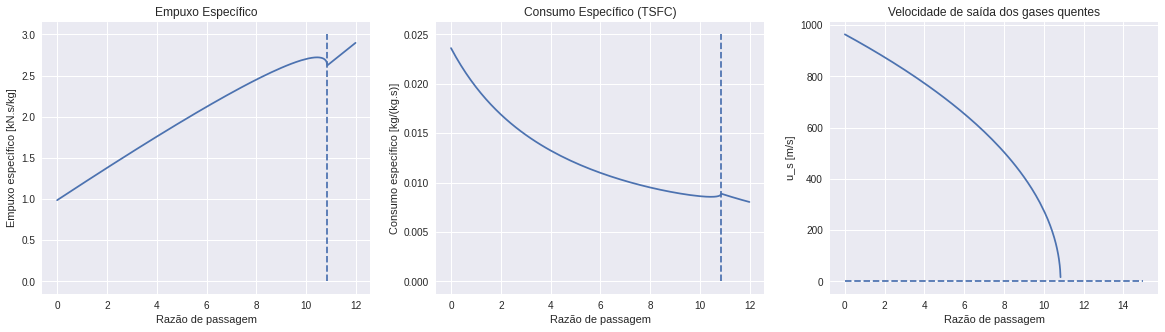

In [130]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
bpr_limit = results.T['u_s'].dropna().idxmin()

plt.sca(ax[0])
plt.plot(results.loc['specific_thrust',:])
plt.title('Empuxo Específico')
plt.xlabel('Razão de passagem')
plt.ylabel('Empuxo específico [kN.s/kg]')
plt.vlines(x=bpr_limit, ymin=0, ymax=3, linestyles='--')

plt.sca(ax[1])
plt.plot(results.loc['TSFC',:])
plt.title('Consumo Específico (TSFC)')
plt.xlabel('Razão de passagem')
plt.ylabel('Consumo específico [kg/(kg.s)]')
plt.vlines(x=bpr_limit, ymin=0, ymax=0.025, linestyles='--')

plt.sca(ax[2])
plt.plot(results.loc['u_s',:])
plt.title('Velocidade de saída dos gases quentes')
plt.xlabel('Razão de passagem')
plt.ylabel('u_s [m/s]')
plt.hlines(y=0, xmin=0, xmax=15, linestyles='--')

print(f"Razão de passagem máxima: {bpr_limit:0.2f}")

In [131]:
# PART 2 ########################################################
"""
1. vazão total de ar (total)
2. consumo de combustível 

para as versões com razão de passagem diferente de zero de tal forma a propiciar o 

!! mesmo empuxo que a versão turbojato !!

"""

results_2 = pd.DataFrame()
results_2.index = results_2.index.set_names('bpr')

model_parameters["bypass_ratio"] = 0 # Turbojet configuration
model_parameters['mass_flow'] = 100 # [kg/s] initial value
tubojet = mf.TurboFan(model_parameters)
turbojet_thrust = float(tubojet.sumarise_results().loc['thrust_total'])

summarise_target_2 = [
    'fuel_consumption',
    'thrust_total',
    'mass_flow'
]

step=0.25
print("Iterating...")
for bpr in np.arange(0, bpr_limit+step, step):
    model_parameters["bypass_ratio"] = bpr
    inlet_mass_flow = 100 # [kg/s]
    tol = 1e-5
    diff = 1.0
    while abs(diff) > tol:
        model_parameters["mass_flow"] = inlet_mass_flow
        turbofan = mf.TurboFan(model_parameters)

        turbofan_thrust = float(turbofan.sumarise_results().loc['thrust_total'])
        diff = (turbofan_thrust - turbojet_thrust)/turbojet_thrust
        inlet_mass_flow = inlet_mass_flow - 100*diff # Update mass flow (increase if thrust is lower)

    results_2[bpr] = (
        turbofan.sumarise().
        append(turbofan.sumarise_results()).
        loc[summarise_target_2]
        )
print("Done!")

results_2

Iterating...
Done!


,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,...,8.75,9.00,9.25,9.50,9.75,10.00,10.25,10.50,10.75,11.00
bpr,,,,,,,,,,,,,,,,,,,,,
fuel_consumption,2.327641,2.216387,2.115553,2.023761,1.939854,1.862867,1.791978,1.726517,1.665878,1.609564,...,0.897111,0.885533,0.874910,0.865339,0.856995,0.850178,0.845484,0.844343,0.852574,0.863463
thrust_total,98.592524,98.592261,98.591856,98.591768,98.591862,98.592006,98.591730,98.591992,98.591862,98.591765,...,98.591752,98.591610,98.591722,98.591567,98.591664,98.591734,98.591775,98.591773,98.591651,98.591710
mass_flow,99.923311,118.934127,136.227919,152.036585,166.552019,179.934781,192.319594,203.823569,214.543520,224.565252,...,375.492856,380.150425,384.980008,390.055509,395.491698,401.470181,408.327770,416.838082,430.051637,444.811567


In [132]:
turbofan.sumarise().append(turbofan.sumarise_results())

,1
bypass_ratio,11.000000
cp_comb,1.110000
f,0.023294
gamma_b,1.350000
gamma_c,1.370000
gamma_d,1.400000
gamma_f,1.400000
gamma_n,1.360000
gamma_nf,1.400000
gamma_t,1.330000


# b)

In [133]:
model_parameters = {
    # Atmospheric condition ##############################################
    'pa': 101.3, # [kPa]
    'ta': 288.3, # [K]
    'r': 288.3,  # [J/(kg*K)] Air Gas Constant
    # Components isentropic efficiencies #################################
    'n_d': 0.97,  # Difuser (Inlet)
    'n_f': 0.85,  # Fan
    'n_c': 0.85,  # High Pressure Compressor
    'n_b': 1.0,   # Combustion Chamber
    'n_t': 0.9,   # Compressor Turbine
    'n_tf': 0.9,  # Fan turbine
    'n_n': 0.98,  # Turbine Nozzle
    'n_nf': 0.98, # Fan Nozzle
    # Average air Cp/Cv inside each component ############################
    'gamma_d': 1.4,   # Difuser (Inlet)
    'gamma_f': 1.4,   # Fan
    'gamma_c': 1.37,  # High Pressure Compressor
    'gamma_b': 1.35,  # Combustion Chamber
    'gamma_t': 1.33,  # Compressor Turbine
    'gamma_tf': 1.33, # Fan turbine
    'gamma_n': 1.36,  # Turbine Nozzle
    'gamma_nf': 1.40, # Fan Nozzle
    # Engine parameters ##################################################
    'prc': 20,         # Crompressor Pressure Ratio
    'prf': 1.4,        # Fan Pressure Ratio
    'bypass_ratio': 0, # Initial value
    # Fuel parameters ####################################################
    'pc_fuel': 45000, # [kJ/kg] Heat of Combustion of the fuel
    'cp_fuel': 1.110, # [kJ/(kg*K)] Specific Heat in the combustion chamber
    # Operating Conditions ###############################################
    't04': 1700,        # [K] (Combustion Chamber Temperature)
    'mach': 0.0,        # Aircraft speed
    'mass_flow': 100.0, # [kg/s] Inlet mass flow
    }

summarise_target = [
    'n1',
    'u_s',
    'hot_mass_flow',
    'hot_specific_thrust',
    'cold_mass_flow',
    'cold_specific_thrust',
    'bypass_ratio', 
    'TSFC',
    'thrust_total',
    'specific_thrust',
    ]

In [134]:
# PART 3 ###################################################################
# Varying T04 - Combustion chamber temperature from 1700 K downwards:


results_b = pd.DataFrame()
results_b.index = results_b.index.set_names('t04')

temp_values = np.arange(1700, 900, -5)
print(temp_values)

for t04 in temp_values:
    model_parameters["t04"] = t04
    turbofan = mf.TurboFan(model_parameters)

    results_b[t04] = (
        turbofan.sumarise().
        append(turbofan.sumarise_results()).
        loc[summarise_target]
        )


results_b

[1700 1695 1690 1685 1680 1675 1670 1665 1660 1655 1650 1645 1640 1635
 1630 1625 1620 1615 1610 1605 1600 1595 1590 1585 1580 1575 1570 1565
 1560 1555 1550 1545 1540 1535 1530 1525 1520 1515 1510 1505 1500 1495
 1490 1485 1480 1475 1470 1465 1460 1455 1450 1445 1440 1435 1430 1425
 1420 1415 1410 1405 1400 1395 1390 1385 1380 1375 1370 1365 1360 1355
 1350 1345 1340 1335 1330 1325 1320 1315 1310 1305 1300 1295 1290 1285
 1280 1275 1270 1265 1260 1255 1250 1245 1240 1235 1230 1225 1220 1215
 1210 1205 1200 1195 1190 1185 1180 1175 1170 1165 1160 1155 1150 1145
 1140 1135 1130 1125 1120 1115 1110 1105 1100 1095 1090 1085 1080 1075
 1070 1065 1060 1055 1050 1045 1040 1035 1030 1025 1020 1015 1010 1005
 1000  995  990  985  980  975  970  965  960  955  950  945  940  935
  930  925  920  915  910  905]


,1700,1695,1690,1685,1680,1675,1670,1665,1660,1655,...,950,945,940,935,930,925,920,915,910,905
t04,,,,,,,,,,,,,,,,,,,,,
n1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
u_s,964.221095,960.901657,957.570111,954.226325,950.870160,947.501478,944.120135,940.725988,937.318888,933.898684,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hot_mass_flow,99.923311,99.923311,99.923311,99.923311,99.923311,99.923311,99.923311,99.923311,99.923311,99.923311,...,99.923311,99.923311,99.923311,99.923311,99.923311,99.923311,99.923311,99.923311,99.923311,99.923311
hot_specific_thrust,986.681923,983.158597,979.623793,976.077376,972.519213,968.949163,965.367087,961.772841,958.166279,954.547251,...,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
cold_mass_flow,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
cold_specific_thrust,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
bypass_ratio,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TSFC,0.023609,0.023559,0.023510,0.023460,0.023411,0.023361,0.023312,0.023262,0.023213,0.023163,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
thrust_total,98.592524,98.240462,97.887253,97.532883,97.177339,96.820608,96.462675,96.103526,95.743147,95.381521,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Temperatura de saída da câmara mínima: 995.00


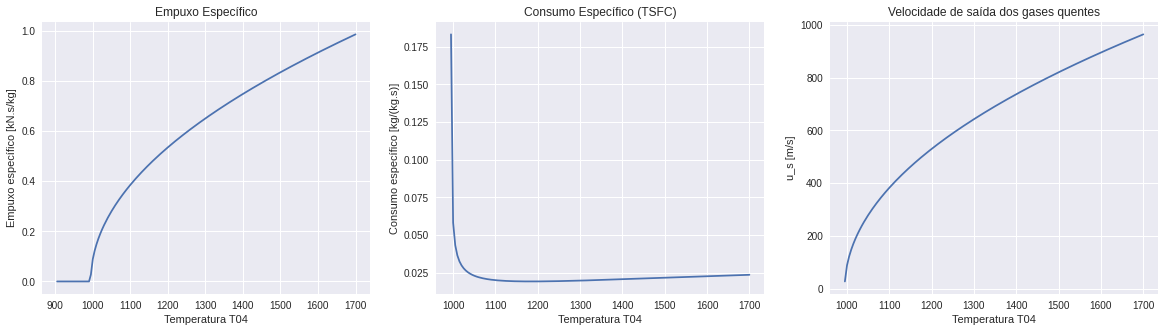

In [135]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
t04_limit = results_b.T['u_s'].dropna().idxmin()

plt.sca(ax[0])
plt.plot(results_b.loc['specific_thrust',:])
plt.title('Empuxo Específico')
plt.xlabel('Temperatura T04')
plt.ylabel('Empuxo específico [kN.s/kg]')
# plt.vlines(x=t04_limit, ymin=0, ymax=3, linestyles='--')

plt.sca(ax[1])
plt.plot(results_b.loc['TSFC',:])
plt.title('Consumo Específico (TSFC)')
plt.xlabel('Temperatura T04')
plt.ylabel('Consumo específico [kg/(kg.s)]')
# plt.vlines(x=t04_limit, ymin=0, ymax=0.025, linestyles='--')

plt.sca(ax[2])
plt.plot(results_b.loc['u_s',:])
plt.title('Velocidade de saída dos gases quentes')
plt.xlabel('Temperatura T04')
plt.ylabel('u_s [m/s]')
# plt.hlines(y=0, xmin=0, xmax=15, linestyles='--')

print(f"Temperatura de saída da câmara mínima: {t04_limit:0.2f}")

# c) Variação de PRF - Fan Pressure Ratio

In [136]:
model_parameters = {
    # Atmospheric condition ##############################################
    'pa': 101.3, # [kPa]
    'ta': 288.3, # [K]
    'r': 288.3,  # [J/(kg*K)] Air Gas Constant
    # Components isentropic efficiencies #################################
    'n_d': 0.97,  # Difuser (Inlet)
    'n_f': 0.85,  # Fan
    'n_c': 0.85,  # High Pressure Compressor
    'n_b': 1.0,   # Combustion Chamber
    'n_t': 0.9,   # Compressor Turbine
    'n_tf': 0.9,  # Fan turbine
    'n_n': 0.98,  # Turbine Nozzle
    'n_nf': 0.98, # Fan Nozzle
    # Average air Cp/Cv inside each component ############################
    'gamma_d': 1.4,   # Difuser (Inlet)
    'gamma_f': 1.4,   # Fan
    'gamma_c': 1.37,  # High Pressure Compressor
    'gamma_b': 1.35,  # Combustion Chamber
    'gamma_t': 1.33,  # Compressor Turbine
    'gamma_tf': 1.33, # Fan turbine
    'gamma_n': 1.36,  # Turbine Nozzle
    'gamma_nf': 1.40, # Fan Nozzle
    # Engine parameters ##################################################
    'prc': 20,         # Crompressor Pressure Ratio
    'prf': 1.4,        # Fan Pressure Ratio
    'bypass_ratio': 5, # Initial value
    # Fuel parameters ####################################################
    'pc_fuel': 45000, # [kJ/kg] Heat of Combustion of the fuel
    'cp_fuel': 1.110, # [kJ/(kg*K)] Specific Heat in the combustion chamber
    # Operating Conditions ###############################################
    't04': 1700,        # [K] (Combustion Chamber Temperature)
    'mach': 0.0,        # Aircraft speed
    'mass_flow': 100.0, # [kg/s] Inlet mass flow
    }

summarise_target = [
    'n1',
    'u_s',
    'hot_mass_flow',
    'hot_specific_thrust',
    'cold_mass_flow',
    'cold_specific_thrust',
    'bypass_ratio', 
    'TSFC',
    'thrust_total',
    'specific_thrust',
    ]

In [139]:
# PART 4 ###################################################################

results_c2 = pd.DataFrame()
results_c2.index = results_c2.index.set_names('prf')

prf_values = np.arange(1.4, 0.01, -0.01)

for prf in prf_values:
    model_parameters["bypass_ratio"] = prf
    turbofan = mf.TurboFan(model_parameters)

    results_c2[prf] = (
        turbofan.sumarise().
        append(turbofan.sumarise_results()).
        loc[summarise_target]
        )


results_c2

,1.40,1.39,1.38,1.37,1.36,1.35,1.34,1.33,1.32,1.31,...,0.11,0.10,0.09,0.08,0.07,0.06,0.05,0.04,0.03,0.02
prf,,,,,,,,,,,,,,,,,,,,,
n1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
u_s,902.584288,903.041487,903.498424,903.955099,904.411514,904.867669,905.323564,905.779199,906.234575,906.689692,...,959.540168,959.966776,960.393170,960.819348,961.245313,961.671064,962.096601,962.521925,962.947036,963.371935
hot_mass_flow,41.634713,41.808917,41.984584,42.161734,42.340386,42.520558,42.702269,42.885541,43.070393,43.256844,...,90.021001,90.839373,91.672762,92.521584,93.386272,94.267274,95.165058,96.080106,97.012923,97.964030
hot_specific_thrust,923.609332,924.077180,924.544761,925.012075,925.479122,925.945902,926.412416,926.878665,927.344649,927.810368,...,981.891957,982.328503,982.764829,983.200935,983.636822,984.072491,984.507941,984.943172,985.378186,985.812982
cold_mass_flow,58.288598,58.114394,57.938726,57.761576,57.582925,57.402753,57.221041,57.037770,56.852918,56.666466,...,9.902310,9.083937,8.250549,7.401727,6.537039,5.656036,4.758253,3.843204,2.910388,1.959281
cold_specific_thrust,338.517342,336.099361,333.681380,331.263399,328.845418,326.427437,324.009456,321.591475,319.173494,316.755513,...,26.597791,24.179810,21.761829,19.343848,16.925867,14.507886,12.089905,9.671924,7.253943,4.835962
bypass_ratio,1.400000,1.390000,1.380000,1.370000,1.360000,1.350000,1.340000,1.330000,1.320000,1.310000,...,0.110000,0.100000,0.090000,0.080000,0.070000,0.060000,0.050000,0.040000,0.030000,0.020000
TSFC,0.018456,0.018485,0.018514,0.018542,0.018571,0.018600,0.018629,0.018658,0.018687,0.018717,...,0.023098,0.023144,0.023189,0.023235,0.023281,0.023327,0.023374,0.023420,0.023467,0.023514
thrust_total,52.548282,52.686616,52.826101,52.966753,53.108585,53.251613,53.395852,53.541317,53.688026,53.835993,...,90.785256,91.430584,92.087733,92.757031,93.438819,94.133450,94.841292,95.562724,96.298144,97.047963


Fan Pressure Ratio máximo: 1.40


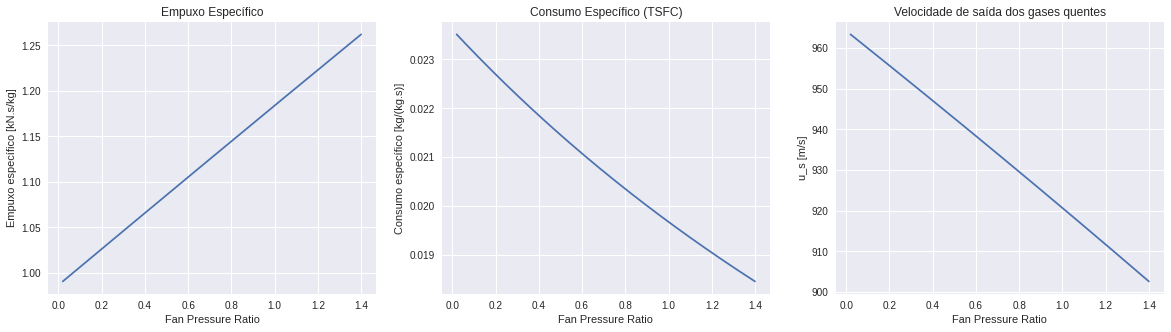

In [140]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
prf_limit = results_c2.T['u_s'].dropna().idxmin()

plt.sca(ax[0])
plt.plot(results_c2.loc['specific_thrust',:])
plt.title('Empuxo Específico')
plt.xlabel('Fan Pressure Ratio')
plt.ylabel('Empuxo específico [kN.s/kg]')
# plt.vlines(x=prf_limit, ymin=0.98, ymax=1.28, linestyles='--')

plt.sca(ax[1])
plt.plot(results_c2.loc['TSFC',:])
plt.title('Consumo Específico (TSFC)')
plt.xlabel('Fan Pressure Ratio')
plt.ylabel('Consumo específico [kg/(kg.s)]')
# plt.vlines(x=prf_limit, ymin=0.018, ymax=0.024, linestyles='--')

plt.sca(ax[2])
plt.plot(results_c2.loc['u_s',:])
plt.title('Velocidade de saída dos gases quentes')
plt.xlabel('Fan Pressure Ratio')
plt.ylabel('u_s [m/s]')
# plt.hlines(y=1000, xmin=0, xmax=1.4, linestyles='--')

print(f"Fan Pressure Ratio máximo: {prf_limit:0.2f}")